# LAB 7: Error analysis

Objectives
* Construct an SVM text classifier using `SVC`: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
* Compare the result to a linear text classifier
* Evaluate its performance and categorize the errors that it makes
* Examine the model's coefficients and decision function values
* Interpret model results using LIME

In [4]:
import pickle

import numpy as np
import pandas as pd
from cytoolz import *
from tqdm.auto import tqdm

tqdm.pandas()

---

## Load data

In [8]:
train, test = pickle.load(open("/data/politics.pkl", "rb"))

In [3]:
train["pol"].value_counts()

False    7999
True     3413
Name: pol, dtype: int64

In [4]:
train.head()

,text,pol
44167,CBOT grain/oilseed receipts and shipments. Gra...,False
32639,Croatian stocks close mixed in livelier trade....,False
13437,S.Korea's Kia Group targets 17.5 pct sales ris...,False
12891,U.S. rice weekly export sales highlights - USD...,False
57095,Israeli army officer punished for Rabin letter...,True


In [6]:
import spacy

nlp = spacy.load(
    "en_core_web_sm",
    exclude=["tagger", "parser", "ner", "lemmatizer", "attribute_ruler"],
)


def tokenize(text):
    doc = nlp.tokenizer(text)
    return [t.norm_ for t in doc if not (t.is_space or t.is_punct or t.like_num)]

In [6]:
train["tokens"] = train["text"].progress_apply(tokenize)
test["tokens"] = test["text"].progress_apply(tokenize)

  0%|          | 0/11412 [00:00<?, ?it/s]

  0%|          | 0/2854 [00:00<?, ?it/s]

------

## SGD Classifier

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

In [8]:
%%time
sgd = make_pipeline(CountVectorizer(analyzer=identity), SGDClassifier())
sgd.fit(train["tokens"], train["pol"])
sgd_predicted = sgd.predict(test["tokens"])
print(classification_report(test["pol"], sgd_predicted))

              precision    recall  f1-score   support

       False       0.94      0.94      0.94      2001
        True       0.87      0.87      0.87       853

    accuracy                           0.92      2854
   macro avg       0.91      0.91      0.91      2854
weighted avg       0.92      0.92      0.92      2854

CPU times: user 1.45 s, sys: 77.1 ms, total: 1.53 s
Wall time: 1.45 s


## SVM Classifier

In [9]:
from sklearn.svm import SVC

In [13]:
%%time
svm = make_pipeline(CountVectorizer(analyzer=identity), SVC(kernel="rbf", C=100))
svm.fit(train["tokens"], train["pol"])
svm_predicted = svm.predict(test["tokens"])
print(classification_report(test["pol"], svm_predicted))

              precision    recall  f1-score   support

       False       0.94      0.95      0.95      2001
        True       0.88      0.87      0.88       853

    accuracy                           0.93      2854
   macro avg       0.91      0.91      0.91      2854
weighted avg       0.93      0.93      0.93      2854

CPU times: user 57.3 s, sys: 105 ms, total: 57.4 s
Wall time: 57.4 s


## Multinomial NB Classifier

In [11]:
from sklearn.naive_bayes import MultinomialNB

In [12]:
%%time
mnb = make_pipeline(CountVectorizer(analyzer=identity), MultinomialNB())
mnb.fit(train["tokens"], train["pol"])
mnb_predicted = mnb.predict(test["tokens"])
print(classification_report(test["pol"], mnb_predicted))

              precision    recall  f1-score   support

       False       0.98      0.88      0.92      2001
        True       0.77      0.95      0.85       853

    accuracy                           0.90      2854
   macro avg       0.87      0.91      0.89      2854
weighted avg       0.91      0.90      0.90      2854

CPU times: user 1.12 s, sys: 8 ms, total: 1.13 s
Wall time: 1.13 s


----

## Hyperparameter search

Find an optimal set of hyperparameters for our models

In [14]:
from scipy.stats.distributions import loguniform, randint, uniform
from sklearn.model_selection import RandomizedSearchCV

### MNB Classifier

In [17]:
mnb_search = RandomizedSearchCV(
    mnb,
    {
        "countvectorizer__min_df": randint(1, 10),
        "countvectorizer__max_df": uniform(0.5, 0.5),
        "multinomialnb__alpha": loguniform(1e-10, 1),
    },
    n_iter=20,
    n_jobs=-1,
    scoring="f1",
)
mnb_search.fit(train["tokens"], train["pol"])
mnb_search.best_params_, mnb_search.best_score_

({'countvectorizer__max_df': 0.7792847004516308,
  'countvectorizer__min_df': 1,
  'multinomialnb__alpha': 1.6309300323042847e-06},
 0.8540628335255851)

<Axes: xlabel='param_multinomialnb__alpha', ylabel='mean_test_score'>

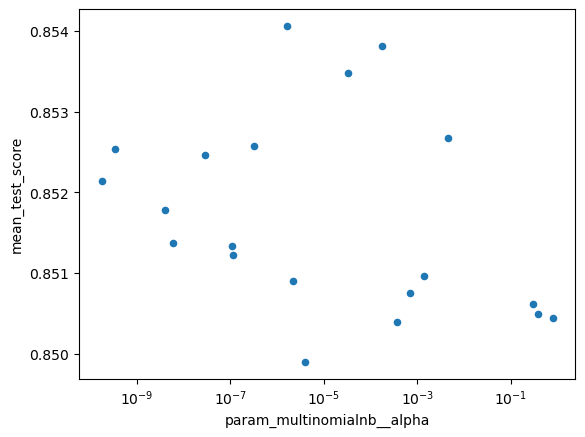

In [18]:
mnb_cv_results = pd.DataFrame(mnb_search.cv_results_)
mnb_cv_results.plot(
    "param_multinomialnb__alpha", "mean_test_score", kind="scatter", logx=True
)

<Axes: xlabel='param_countvectorizer__min_df', ylabel='mean_test_score'>

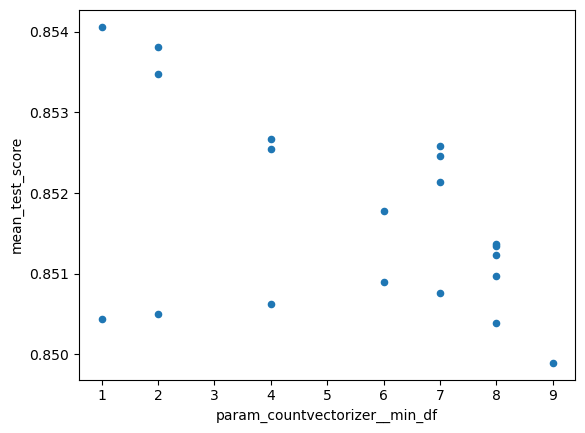

In [19]:
mnb_cv_results.plot("param_countvectorizer__min_df", "mean_test_score", kind="scatter")

<Axes: xlabel='param_countvectorizer__max_df', ylabel='mean_test_score'>

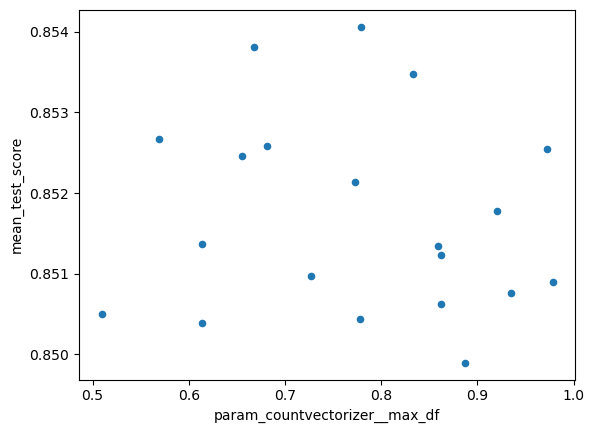

In [20]:
mnb_cv_results.plot("param_countvectorizer__max_df", "mean_test_score", kind="scatter")

In [25]:
mnb.set_params(**mnb_search.best_params_)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(analyzer=<cyfunction identity at 0x2aeb65597e00>,
                                 max_df=0.7792847004516308)),
                ('multinomialnb', MultinomialNB(alpha=1.6309300323042847e-06))])

In [27]:
mnb.fit(train["tokens"], train["pol"])
mnb_predicted = mnb.predict(test["tokens"])
print(classification_report(test["pol"], mnb_predicted))

              precision    recall  f1-score   support

       False       0.96      0.90      0.93      2001
        True       0.79      0.90      0.84       853

    accuracy                           0.90      2854
   macro avg       0.87      0.90      0.89      2854
weighted avg       0.91      0.90      0.90      2854



### SGD Classifier

In [34]:
sgd_search = RandomizedSearchCV(
    sgd,
    {
        "countvectorizer__min_df": randint(1, 10),
        "countvectorizer__max_df": uniform(0.5, 0.5),
        "sgdclassifier__alpha": loguniform(1e-10, 1.0),
    },
    n_iter=20,
    n_jobs=-1,
    scoring="f1",
)

sgd_search.fit(train["tokens"], train["pol"])
sgd_search.best_params_, sgd_search.best_score_

({'countvectorizer__max_df': 0.9648995962853211,
  'countvectorizer__min_df': 9,
  'sgdclassifier__alpha': 0.040598083609988865},
 0.8848707838603722)

<Axes: xlabel='param_sgdclassifier__alpha', ylabel='mean_test_score'>

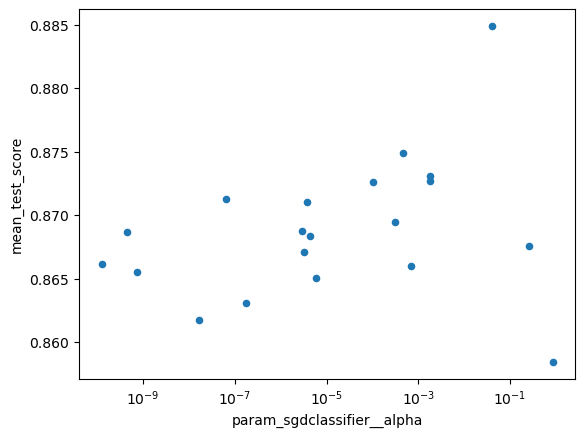

In [35]:
sgd_cv_results = pd.DataFrame(sgd_search.cv_results_)
sgd_cv_results.plot(
    "param_sgdclassifier__alpha", "mean_test_score", kind="scatter", logx=True
)

In [36]:
sgd.set_params(**sgd_search.best_params_)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(analyzer=<cyfunction identity at 0x2aeb65597e00>,
                                 max_df=0.9648995962853211, min_df=9)),
                ('sgdclassifier', SGDClassifier(alpha=0.040598083609988865))])

In [37]:
sgd.fit(train["tokens"], train["pol"])
sgd_predicted = sgd.predict(test["tokens"])
print(classification_report(test["pol"], sgd_predicted))

              precision    recall  f1-score   support

       False       0.94      0.95      0.95      2001
        True       0.89      0.87      0.88       853

    accuracy                           0.93      2854
   macro avg       0.92      0.91      0.91      2854
weighted avg       0.93      0.93      0.93      2854



### SVM Classifier

In [46]:
%%time
svm_search = RandomizedSearchCV(
    svm,
    {
        "countvectorizer__min_df": randint(1, 10),
        "countvectorizer__max_df": uniform(0.5, 0.5),
        "svc__C": [0.1, 1, 10, 100, 1000],
    },
    n_iter=20,
    n_jobs=-1,
    scoring="f1",
)

svm_search.fit(train["tokens"], train["pol"])
svm_search.best_params_, svm_search.best_score_

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


CPU times: user 2min 8s, sys: 9.56 s, total: 2min 18s
Wall time: 20min 4s


({'countvectorizer__max_df': 0.886087363367857,
  'countvectorizer__min_df': 3,
  'svc__C': 10},
 0.8813708089867616)

In [47]:
svm_cv_results = pd.DataFrame(svm_search.cv_results_)
svm_cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_countvectorizer__max_df,param_countvectorizer__min_df,param_svc__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,31.806279,0.678173,7.088277,0.175928,0.596971,4,1,{'countvectorizer__max_df': 0.5969706209688668...,0.885714,0.869631,0.875758,0.886228,0.878630,0.879192,0.006254,7
1,30.471885,0.350470,7.000969,0.311457,0.540486,6,1,{'countvectorizer__max_df': 0.5404856393648962...,0.884558,0.870943,0.880000,0.882397,0.876957,0.878971,0.004744,8
2,31.884160,1.276039,7.191510,0.377794,0.528439,1,100,{'countvectorizer__max_df': 0.5284393588919563...,0.878378,0.875466,0.884101,0.886931,0.880531,0.881081,0.004061,2
3,30.352198,0.584769,7.100303,0.342717,0.527921,6,1,{'countvectorizer__max_df': 0.5279214599726969...,0.884558,0.870943,0.880000,0.882397,0.876957,0.878971,0.004744,8
4,28.563150,1.010313,6.458214,0.457757,0.591068,9,100,{'countvectorizer__max_df': 0.5910679434259463...,0.879699,0.873323,0.883929,0.884164,0.882051,0.880633,0.003991,5


<Axes: xlabel='param_svc__C', ylabel='mean_test_score'>

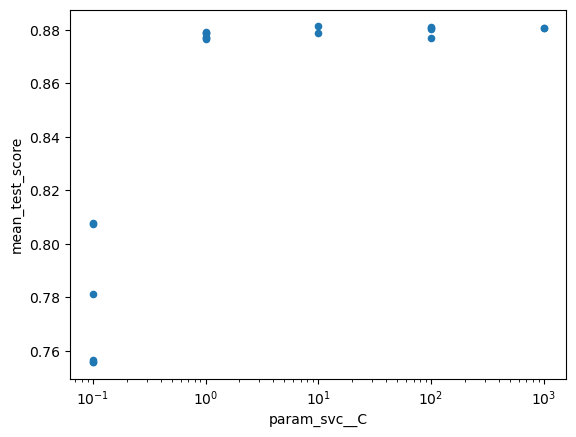

In [48]:
svm_cv_results.plot(
    "param_svc__C", "mean_test_score", kind="scatter", logx=True
)

In [49]:
svm.set_params(**svm_search.best_params_)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(analyzer=<cyfunction identity at 0x2aeb65597e00>,
                                 max_df=0.886087363367857, min_df=3)),
                ('svc', SVC(C=10))])

In [50]:
svm.fit(train["tokens"], train["pol"])
svm_predicted = svm.predict(test["tokens"])
print(classification_report(test["pol"], svm_predicted))

              precision    recall  f1-score   support

       False       0.94      0.96      0.95      2001
        True       0.90      0.87      0.88       853

    accuracy                           0.93      2854
   macro avg       0.92      0.91      0.92      2854
weighted avg       0.93      0.93      0.93      2854



---

## Compare optimized model to baseline

In [51]:
sgd_predicted = sgd.predict(test["tokens"])
print(classification_report(test["pol"], sgd_predicted))

              precision    recall  f1-score   support

       False       0.94      0.95      0.95      2001
        True       0.89      0.87      0.88       853

    accuracy                           0.93      2854
   macro avg       0.92      0.91      0.91      2854
weighted avg       0.93      0.93      0.93      2854



In [52]:
svm_predicted = svm.predict(test["tokens"])
print(classification_report(test["pol"], svm_predicted))

              precision    recall  f1-score   support

       False       0.94      0.96      0.95      2001
        True       0.90      0.87      0.88       853

    accuracy                           0.93      2854
   macro avg       0.92      0.91      0.92      2854
weighted avg       0.93      0.93      0.93      2854



In [53]:
mnb_predicted = mnb.predict(test["tokens"])
print(classification_report(test["pol"], mnb_predicted))

              precision    recall  f1-score   support

       False       0.96      0.90      0.93      2001
        True       0.79      0.90      0.84       853

    accuracy                           0.90      2854
   macro avg       0.87      0.90      0.89      2854
weighted avg       0.91      0.90      0.90      2854



In [54]:
sgd_f1 = f1_score(test["pol"], sgd_predicted)
svm_f1 = f1_score(test["pol"], svm_predicted)
mnb_f1 = f1_score(test["pol"], mnb_predicted)

In [55]:
sgd_f1, svm_f1, mnb_f1, sgd_f1 - svm_f1, sgd_f1-mnb_f1

(0.8795252225519289,
 0.881477069684336,
 0.8438356164383561,
 -0.0019518471324071474,
 0.03568960611357275)

By observing f1 scores, we can see that svm has performed well over sgd and mnb, but it was computationally expensive to build and tune the svm model. SGD has similar score, only slightly less than SVM and is quick to model exponentially. It is better to chose sgd model looking at the performance metrics.

In [57]:
from scipy.stats import binomtest, wilcoxon

In [64]:
diff_sgd_svm = (sgd_predicted == test["pol"]).astype(int) - (
    svm_predicted == test["pol"]
).astype(int)

sum(diff == 1), sum(diff == -1), sum(diff == 0)

(157, 75, 2622)

Majority predictions from both SVM and SGD are similar, The predictions where SVM and SGD differed are also in similar number.

In [65]:
diff_sgd_mnb = (sgd_predicted == test["pol"]).astype(int) - (
    mnb_predicted == test["pol"]
).astype(int)

sum(diff == 1), sum(diff == -1), sum(diff == 0)

(157, 75, 2622)

Same predictions between SGD and MNB is also nat far away from the above number. But the number of predictions where SGD predicted true when MNB is false is greater than the number of predictions where SGD predicted fasle when MNB is True, and the former is double than latter.

In [66]:
binomtest(sum(diff_sgd_svm == 1), len(diff_sgd_svm), alternative="greater")

BinomTestResult(k=40, n=2854, alternative='greater', statistic=0.01401541695865452, pvalue=1.0)

In [67]:
binomtest(sum(diff_sgd_mnb == 1), len(diff_sgd_mnb), alternative="greater")

BinomTestResult(k=157, n=2854, alternative='greater', statistic=0.05501051156271899, pvalue=1.0)

In [68]:
wilcoxon(diff_sgd_svm, alternative="greater")

WilcoxonResult(statistic=1700.0, pvalue=0.6687397082299713)

In [69]:
wilcoxon(diff_sgd_mnb, alternative="greater")

WilcoxonResult(statistic=18290.5, pvalue=3.6512684196144544e-08)

-----

## Save models

Rebuild model with the tokenizer included and save

All models with tuned hyperparameters and tokenizer.

In [12]:
%%time
sgd_all = make_pipeline(
    CountVectorizer(preprocessor=identity,tokenizer=tokenize),
    TfidfTransformer(),
    SGDClassifier(),
)
sgd_all.fit(train["text"], train["pol"])

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: user 9.1 s, sys: 74.2 ms, total: 9.17 s
Wall time: 9.09 s


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(preprocessor=<cyfunction identity at 0x2ae2901d9b10>,
                                 tokenizer=<function tokenize at 0x2ae29473f5b0>)),
                ('tfidftransformer', TfidfTransformer()),
                ('sgdclassifier', SGDClassifier())])

In [71]:
%%time
svm_all = make_pipeline(
    CountVectorizer(preprocessor=identity, tokenizer=tokenize, min_df=3, max_df=0.886),
    TfidfTransformer(),
    SVC(kernel="rbf", C=10),
)
svm_all.fit(train["text"], train["pol"])

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: user 2min 5s, sys: 124 ms, total: 2min 5s
Wall time: 2min 5s


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.886, min_df=3,
                                 preprocessor=<cyfunction identity at 0x2aeb65597e00>,
                                 tokenizer=<function tokenize at 0x2aeb65a323b0>)),
                ('tfidftransformer', TfidfTransformer()), ('svc', SVC(C=10))])

In [72]:
%%time
mnb_all = make_pipeline(
    CountVectorizer(preprocessor=identity, min_df=1, max_df=0.779,tokenizer=tokenize),
    TfidfTransformer(),
    MultinomialNB(alpha=1e-6),
)
mnb_all.fit(train["text"], train["pol"])

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


CPU times: user 6.5 s, sys: 3.7 ms, total: 6.5 s
Wall time: 6.5 s


Pipeline(steps=[('countvectorizer',
                 CountVectorizer(max_df=0.779,
                                 preprocessor=<cyfunction identity at 0x2aeb65597e00>,
                                 tokenizer=<function tokenize at 0x2aeb65a323b0>)),
                ('tfidftransformer', TfidfTransformer()),
                ('multinomialnb', MultinomialNB(alpha=1e-06))])

In [13]:
import cloudpickle

In [74]:
cloudpickle.dump(sgd_all, open("sgd.model", "wb"))
cloudpickle.dump(svm_all, open("svm.model", "wb"))
cloudpickle.dump(mnb_all, open("mnb.model", "wb"))

It was quick to train and tune the SGD model, and SVM took a lot of time. But once the model has been finally tuned and saved, it can be used easily to do predictions, let's compare the errors after we save the models.